In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd

from ccHBGF import find_consensus, config

from igraph import Graph
from scanpy import _utils
from typing import Any

In [ ]:
config.LOG_LEVEL = 2 # Info level (0=silent, 1=warnings)

### Let's load an example dataset from ScanPy

In [11]:
adata = sc.datasets.pbmc3k()
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### Let's preprocess for clustering

In [12]:
# Denoise and normalize the the data
sc.pp.highly_variable_genes(adata, flavor='seurat_v3_paper', n_top_genes=3_000, inplace=True, subset=True)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

adata

AnnData object with n_obs × n_vars = 2700 × 3000
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p'

In [13]:
# Calculate Neighbourhood Graph
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X_pca')

# Calculate UMAP for later visualization
sc.tl.umap(adata, random_state=0)

adata

AnnData object with n_obs × n_vars = 2700 × 3000
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Let's run leiden clustering for 100 different seeds

In [14]:
# Adapted from ScanPy
def igraph_leiden(
    g: Graph,
    resolution: float = 1.0,
    n_iterations: int = 2,
    random_state: _utils.AnyRandom = 0,
    **clustering_args: dict[str, Any]
) -> list[int]:
    """
    connectivities_key = adata.uns['neighbors']['connectivities_key']
    adata_igraph = sc._utils.get_igraph_from_adjacency(adata.obsp[connectivities_key])
    """
    # Copy clustering arguments and set number of iterations
    clustering_args = dict(clustering_args)
    clustering_args["n_iterations"] = n_iterations
    
    # Set resolution if provided
    if resolution is not None:
        clustering_args["resolution"] = resolution

    # Set default objective function if not specified
    clustering_args.setdefault("objective_function", "modularity")
    
    # Run Leiden clustering with specified random state
    with _utils.set_igraph_random_state(random_state):
        part = g.community_leiden(**clustering_args)

    return part.membership

connectivities_key = adata.uns['neighbors']['connectivities_key']
adata_igraph = sc._utils.get_igraph_from_adjacency(adata.obsp[connectivities_key])

In [15]:
N_SEEDS = 100
RESOLUTION = 5

solutions_matrix = np.zeros((adata.shape[0], N_SEEDS))

for seed in range(N_SEEDS):
    solutions_matrix[:, seed] = igraph_leiden(adata_igraph, resolution=RESOLUTION, random_state=seed)

### Let's find the consensus labels between these solutions

In [ ]:
consensus_labels = find_consensus(solutions_matrix, init='orthogonal', tol=0.1, random_state=0)

ccHBGF[12:11:11](INFO): Detected 51 clusters.
ccHBGF[12:11:11](INFO): Graph adjacency matrix (A) constructed with shape (2700, 4682)
ccHBGF[12:11:11](INFO): Transformed A to Laplacian Matrix (L) of shape (2700, 4682)
ccHBGF[12:11:11](INFO): Decomposed L into Singular Values (SVs)
ccHBGF[12:11:11](INFO): Normalized SVs
ccHBGF[12:11:11](INFO): Initialized Centers
ccHBGF[12:11:11](INFO): Orthogonalized Centers
ccHBGF[12:11:12](INFO): KMeans model fitted to UVt
ccHBGF[12:11:12](INFO): Consensus Labels Found


### Let's visualize the resulting clusters

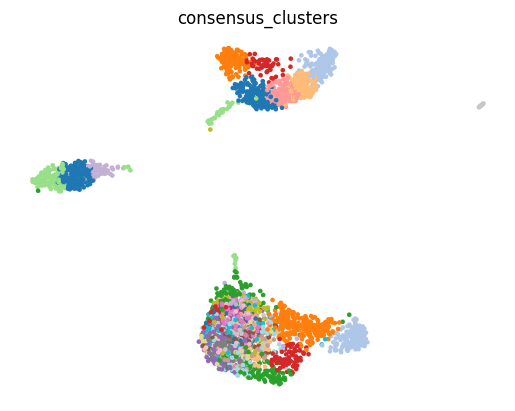

In [17]:
adata.obs['consensus_clusters'] = pd.Categorical(consensus_labels)

sc.pl.umap(adata, color='consensus_clusters', legend_loc=None, palette='tab20', frameon=False)